# A2: Gesture Recognizer

## Notebook Layout
1. Setup: imports, definitions, and classes

In [29]:
# This cell includes all imports and global definitions for this notebook.
# It should be run prior to any of the other cells.

import copy
import itertools
import ntpath
import os
import random
import sys

import ipywidgets
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
import scipy

from scipy import signal

from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn import svm

!{sys.executable} -m pip install fastdtw
import fastdtw


# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Gyroscope", *parsedGyroLogData[1:])
            
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
# This cell contains our file handling and parsing related functions


# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = '{}_{}'.format(os.path.basename(path_to_dir), filenameParts[0])
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(path_to_dir, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            for sample in [
                gestureTrial.accel.x, gestureTrial.accel.y, gestureTrial.accel.z,
                gestureTrial.gyro.x, gestureTrial.gyro.y, gestureTrial.gyro.z]:
                if maxArrayLength < len(sample):
                    maxArrayLength = len(sample)
                    print(maxArrayLength)
                    trialWithMostSensorEvents = gestureTrial           
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Load the data

jonTrials = parse_and_create_gesture_trials('./JonGestureLogs')
myTrials = parse_and_create_gesture_trials('./gesture_data')

mapGestureToTrials = copy.copy(jonTrials)
mapGestureToTrials.update(myTrials)

Found 100 csv files in ./JonGestureLogs
Found 10 gestures
108
120
Found 5 trials for 'JonGestureLogs_Midair Counter Clockwise O'
134
135
144
Found 5 trials for 'JonGestureLogs_Underhand Bowling'
Found 5 trials for 'JonGestureLogs_Baseball Throw'
Found 5 trials for 'JonGestureLogs_Midair Clockwise O'
Found 5 trials for 'JonGestureLogs_Midair Zorro Z'
Found 5 trials for 'JonGestureLogs_Forehand Tennis'
Found 5 trials for 'JonGestureLogs_Midair S'
146
Found 5 trials for 'JonGestureLogs_Backhand Tennis'
147
184
187
Found 5 trials for 'JonGestureLogs_Shake'
243
323
Found 5 trials for 'JonGestureLogs_At Rest'
Max trial length across all gesture is 'JonGestureLogs_At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match
Found 166 csv files in ./gesture_data
Found 12 gestures
103
104
111
348
Found 7 trials for 'gesture_data_Shake'
Found 6 trials for 'gesture_data_Backhand Tennis'
Found 6 trials for 'gesture_data_Midair S'
Found 7 trials for 'gesture_data_Underhand Bowling'
Found 8

## Visualization

To make visualizing a given task easier, we use a dropdown menu to select the gesture we're attempting to debug.  For convenience, two drop downs are available for comparing gestures side-by-side.

In [3]:
def DisplayDebugAccelVisualization(gestureName):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]

    trialNum = 1
    for trial in gestureTrials:
        axes[0][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[0][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][0].plot(trial.gyro.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][1].plot(trial.gyro.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][2].plot(trial.gyro.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][3].plot(trial.gyro.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].legend(loc='right')
    axes[0][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].legend(loc='right')
    axes[0][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].legend(loc='right')
    axes[0][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].legend(loc='right')
    axes[0][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].legend(loc='right')
    axes[1][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].legend(loc='right')
    axes[1][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].legend(loc='right')
    axes[1][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].legend(loc='right')
    axes[1][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));


interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

In [4]:
def DisplayDebugSpectrumVisualization(gestureName):
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(25, 15))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]

    for trial in gestureTrials:
        axes[0][0].specgram(trial.accel.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][1].specgram(trial.accel.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][2].specgram(trial.accel.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[0][3].specgram(trial.accel.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][0].specgram(trial.gyro.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][1].specgram(trial.gyro.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][2].specgram(trial.gyro.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[1][3].specgram(trial.gyro.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][0].psd(trial.accel.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][1].psd(trial.accel.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][2].psd(trial.accel.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[2][3].psd(trial.accel.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][0].psd(trial.gyro.x, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][1].psd(trial.gyro.y, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][2].psd(trial.gyro.z, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        axes[3][3].psd(trial.gyro.mag, NFFT=64, Fs=50, noverlap=0, alpha=0.7)
        
    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].set(xlabel='Time', ylabel='Frequency')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].set(xlabel='Time', ylabel='Frequency')
    
    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].set(xlabel='Time', ylabel='Frequency')
    
    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].set(xlabel='Time', ylabel='Frequency')
    
    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].set(xlabel='Time', ylabel='Frequency')
    
    axes[2][0].set_title(gestureName + " (Accel X)")
    axes[2][0].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][1].set_title(gestureName + " (Accel Y)")
    axes[2][1].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][2].set_title(gestureName + " (Accel Z)")
    axes[2][2].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[2][3].set_title(gestureName + " (Accel Mag)")
    axes[2][3].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][0].set_title(gestureName + " (Gyro X)")
    axes[3][0].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][1].set_title(gestureName + " (Gyro Y)")
    axes[3][1].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][2].set_title(gestureName + " (Gyro Z)")
    axes[3][2].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
    axes[3][3].set_title(gestureName + " (Gyro Mag)")
    axes[3][3].set(xlabel='Frequency', ylabel='Spectral Density (dB/Hz)')
    
ipywidgets.interact(DisplayDebugSpectrumVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugSpectrumVisualization, gestureName=sorted(mapGestureToTrials.keys()));


interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='gestureName', options=('JonGestureLogs_At Rest', 'JonGestureLogs_Backhand Tennis', 'JonGestureLogs_Baseball Throw', 'JonGestureLogs_Forehand Tennis', 'JonGestureLogs_Midair Clockwise O', 'JonGestureLogs_Midair Counter Clockwise O', 'JonGestureLogs_Midair S', 'JonGestureLogs_Midair Zorro Z', 'JonGestureLogs_Shake', 'JonGestureLogs_Underhand Bowling', 'gesture_data_At Rest', 'gesture_data_Backhand Tennis', 'gesture_data_Baseball Throw', 'gesture_data_Chopping', 'gesture_data_Conducting', 'gesture_data_Forehand Tennis', 'gesture_data_Midair Clockwise O', 'gesture_data_Midair Counter Clockwise O', 'gesture_data_Midair S', 'gesture_data_Midair Zorro Z', 'gesture_data_Shake', 'gesture_data_Underhand Bowling'), value='JonGestureLogs_At Rest'), Output()), _dom_classes=('widget-interact',))

## Naive Matcher
After looking at the Acceleration, gyroscope, and frequency domain information about the given gestures, we can start making a basic shap matcher to attempt to classify gestures.

A simple smoothing pass is sufficient to get around 85+% accuracy.  This is, in part, because there is not likely to be a significant bias or trend over the course of gesture recording.

The non-periodic nature of most of the gestures meant that full spectral plots also werent significantly indicative of a particular gesture except in the case of highly periodic gestures like "shake"

JonGestureLogs_Underhand Bowling 0.0/5.0 (0.0%)
JonGestureLogs_Midair Clockwise O 0.0/5.0 (0.0%)
JonGestureLogs_Shake 0.0/5.0 (0.0%)
JonGestureLogs_Midair S 0.0/5.0 (0.0%)
JonGestureLogs_At Rest 0.0/5.0 (0.0%)
JonGestureLogs_Midair Zorro Z 0.0/5.0 (0.0%)
JonGestureLogs_Forehand Tennis 0.0/5.0 (0.0%)
JonGestureLogs_Midair Counter Clockwise O 0.0/5.0 (0.0%)
JonGestureLogs_Baseball Throw 0.0/5.0 (0.0%)
JonGestureLogs_Backhand Tennis 0.0/5.0 (0.0%)
0.0 of 50.0 correct: 0.0%


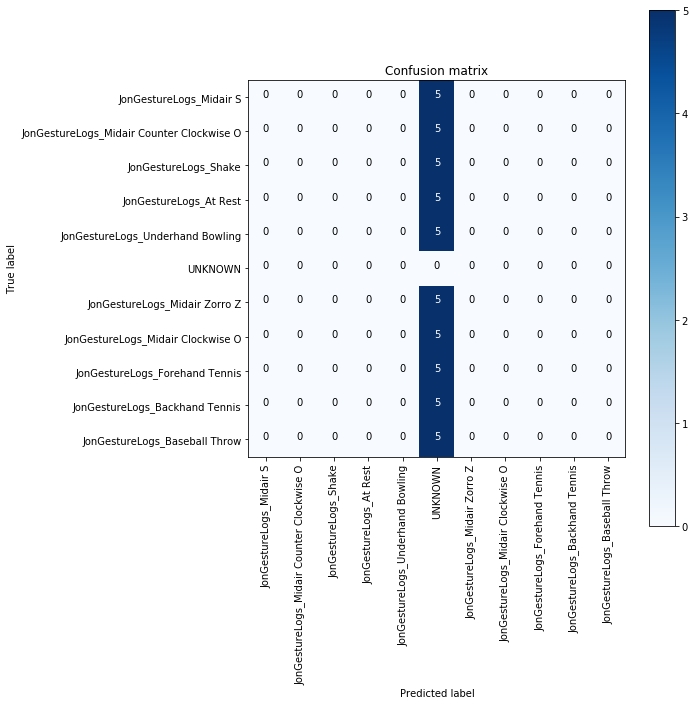

In [23]:
# Some basic testing functions that can be used for any model.

def PrintResults(results):
    correct = 0.0
    total = 0.0
    for truth, prediction_list in results.items():
        label = truth
        local_correct = 0.
        local_total = 0.
        for prediction in prediction_list:
            total += 1.0
            local_total += 1.0
            if truth == prediction:
                correct += 1.0
                local_correct += 1.0
            
        print ('{} {}/{} ({}%)'.format(truth, local_correct, local_total, (local_correct / local_total * 100)))
                
    print('{} of {} correct: {}%'.format(correct, total, (correct / total)))    


def PlotConfusionMatrix(results, title='Confusion matrix', cmap=plt.cm.Blues):
    """This function prints and plots the confusion matrix."""
    true_values = []
    predictions = []
    labels = set()

    for truth, prediction_list in results.items():
        for prediction in prediction_list:
            true_values.append(truth)
            predictions.append(prediction)
            labels.add(truth)
            labels.add(prediction)
                
    labels = list(labels)
    
    cm = confusion_matrix(true_values, predictions, labels)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    
def CreateKFolds(arr, k):
    random.shuffle(arr)
    return [arr[i:i + int(len(arr) / k)] for i in range(0, len(arr), int(len(arr) / k))]


def Test(model, trials, k=5):
    """Test the given model on the given trials using k-fold validation."""
    flat_list = [trial for trials in trials.values() for trial in trials]
    folds = CreateKFolds(flat_list, k)

    results = {}
    for i in range(len(folds)):
        training_data = []
        for j in range(len(folds)):
            if i == j:
                continue
            training_data.extend(folds[j])
        model.train(training_data)
        for trial in folds[i]:
            if trial.gestureName not in results:
                results[trial.gestureName] = []
            results[trial.gestureName].append(model.predict(trial))
        model.reset()
    return results


class BadModel:
    def __init__(self):
        pass
    
    def train(self, data):
        pass
    
    def reset(self):
        pass
    
    def predict(self, trial):
        return 'UNKNOWN'
    
    
# model = BadModel()
# results = Test(model, jonTrials)
# PrintResults(results)
# PlotConfusionMatrix(results)

JonGestureLogs_Backhand Tennis
JonGestureLogs_Shake
JonGestureLogs_Midair S
JonGestureLogs_Midair S
JonGestureLogs_Midair Clockwise O
JonGestureLogs_Midair Clockwise O
JonGestureLogs_Forehand Tennis
JonGestureLogs_Midair Zorro Z
JonGestureLogs_Midair Counter Clockwise O
JonGestureLogs_Shake
JonGestureLogs_Backhand Tennis
JonGestureLogs_Midair Clockwise O
JonGestureLogs_Baseball Throw
JonGestureLogs_Backhand Tennis
JonGestureLogs_Forehand Tennis
JonGestureLogs_Midair Clockwise O
JonGestureLogs_Baseball Throw
JonGestureLogs_Midair S
JonGestureLogs_At Rest
JonGestureLogs_Midair Zorro Z
JonGestureLogs_Midair Zorro Z
JonGestureLogs_Underhand Bowling
JonGestureLogs_Midair Zorro Z
JonGestureLogs_Forehand Tennis
JonGestureLogs_Midair Clockwise O
JonGestureLogs_At Rest
JonGestureLogs_Baseball Throw
JonGestureLogs_Midair S
JonGestureLogs_Midair Zorro Z
JonGestureLogs_Forehand Tennis
JonGestureLogs_Backhand Tennis
JonGestureLogs_Backhand Tennis
JonGestureLogs_Baseball Throw
JonGestureLogs_Midair 

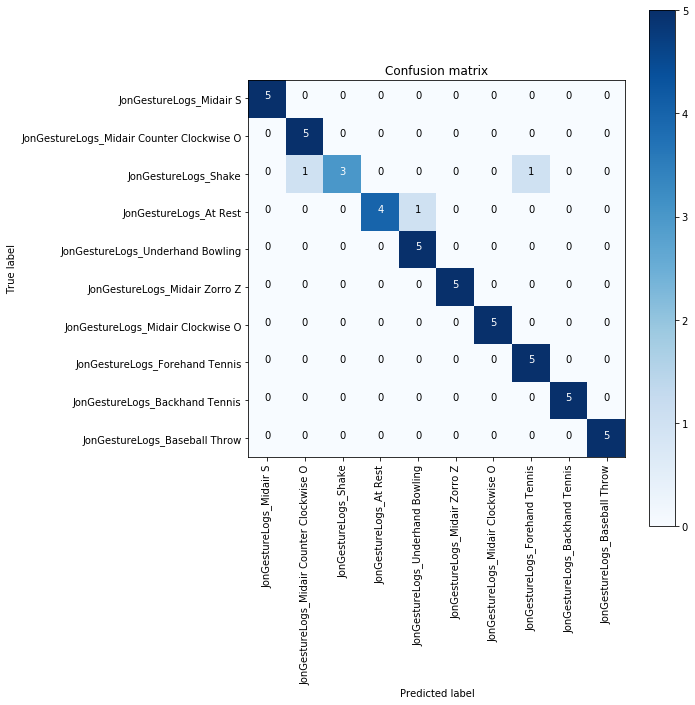

gesture_data_Midair Zorro Z


KeyboardInterrupt: 

In [26]:
class ShapeMatcherModel(object):
    def __init__(self):
        self.stored_data = None
        
    def train(self, data):
        self.stored_data = data
        
    def reset(self):
        self.stored_data = None
        
    def predict(self, trial):
        minDiff = 100000000000000.0  # A very large number
        match = None
        for candidate in self.stored_data:
            diff = CalculateDifference(trial, candidate)
            if diff < minDiff:
                minDiff = diff
                match = candidate
        prediction = 'UNKNOWN' if not match else match.gestureName
        print(prediction)
        return prediction
    
    def CalculateDifference(trial1, trial2):
        """Calculates the difference between two Trial objects."""
        diff = 0.0
        diff += DiffAxis(trial1.accel.x, trial2.accel.x)
        diff += DiffAxis(trial1.accel.y, trial2.accel.y)
        diff += DiffAxis(trial1.accel.z, trial2.accel.z)
        diff += DiffAxis(trial1.accel.mag, trial2.accel.mag)
        diff += DiffAxis(trial1.accel.x, trial2.accel.x)
        diff += DiffAxis(trial1.accel.y, trial2.accel.y)
        diff += DiffAxis(trial1.accel.z, trial2.accel.z)
        diff += DiffAxis(trial1.accel.mag, trial2.accel.mag)
        return diff

    def DiffAxis(first, second):
        """Calculate the diff between two raw numpy arrays"""
        #Smooth the signals:
        #first = Smooth(first)
        #second = Smooth(second)

        #first = first / np.linalg.norm(first)
        #second = second / np.linalg.norm(second)
        dtw_distance, _ = fastdtw.fastdtw(first, second, dist=scipy.spatial.distance.euclidean)
        return dtw_distance

    def Smooth(arr, factor=15):
        """ From: http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html"""
        s = np.r_[arr[factor-1:0:-1], arr, arr[-2:-factor-1:-1]]
        w = np.ones(factor, 'd')
        return np.convolve(w/w.sum(), s, mode='valid')


model = ShapeMatcherModel()
jonResults = Test(model, jonTrials)
PrintResults(jonResults)
PlotConfusionMatrix(jonResults)

myResults = Test(model, myTrials)
PrintResults(myResults)
PlotConfusionMatrix(myResults)

## Using a SVM

Now we try to do the same predictions using a SVM.

In [41]:
class SVMModel:
    NUM_FEATURES = 3
    
    def __init__(self):
        self.model = svm.SVC()

    def train(self, data):
        features = np.array([])
        labels = np.array([])
        for datum in data:
            features = np.append(features, self.GetFeatures(datum))
            labels = np.append(labels, datum.gestureName)

        features = features.reshape(-1, self.NUM_FEATURES)
        self.model.fit(features, labels)
        
    def reset(self):
        self.model = svm.SVC()
    
    def predict(self, trial):
        features = self.GetFeatures(trial)
        return self.model.predict(features)
    
    def GetFeatures(self, trial):
        xMax = trial.accel.x.max()
        yMax = trial.accel.y.max()
        zMax = trial.accel.z.max()
        return [[xMax, yMax, zMax]]
    
model = SVMModel()
jonResults = Test(model, jonTrials)
PrintResults(jonResults)
PlotConfusionMatrix(jonResults)

myResults = Test(model, myTrials)
PrintResults(myResults)
PlotConfusionMatrix(myResults)
        

(40, 3)
(40, 3)
(40, 3)
(40, 3)
(40, 3)
JonGestureLogs_Shake 0.0/5.0 (0.0%)
JonGestureLogs_Baseball Throw 0.0/5.0 (0.0%)
JonGestureLogs_Underhand Bowling 0.0/5.0 (0.0%)
JonGestureLogs_At Rest 2.0/5.0 (40.0%)
JonGestureLogs_Midair S 0.0/5.0 (0.0%)
JonGestureLogs_Forehand Tennis 0.0/5.0 (0.0%)
JonGestureLogs_Midair Clockwise O 0.0/5.0 (0.0%)
JonGestureLogs_Midair Zorro Z 2.0/5.0 (40.0%)
JonGestureLogs_Backhand Tennis 0.0/5.0 (0.0%)
JonGestureLogs_Midair Counter Clockwise O 0.0/5.0 (0.0%)
4.0 of 50.0 correct: 0.08%


TypeError: unhashable type: 'numpy.ndarray'

## Experiments and Trials
This is some backmatter for recording different experiments with respect to data processing and model training.

In [ ]:
def DisplayDebugAccelVisualization(gestureName):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    fig.subplots_adjust(hspace=0.5)

    gestureTrials = mapGestureToTrials[gestureName]
    
    avg_x = np.zeros([len(gestureTrials[0].accel.x)], dtype=float)
    avg_y = np.zeros([len(gestureTrials[0].accel.y)], dtype=float)
    avg_z = np.zeros([len(gestureTrials[0].accel.z)], dtype=float)
    for trial in gestureTrials:
        avg_x += trial.accel.x
        avg_y += trial.accel.y
        avg_z += trial.accel.z

    avg_x = avg_x / len(gestureTrials)
    avg_y = avg_y / len(gestureTrials)
    avg_z = avg_z / len(gestureTrials)
    axes[0][0].plot(avg_x / np.linalg.norm(avg_x), alpha=0.9, label="Average")
    axes[0][1].plot(avg_y / np.linalg.norm(avg_y), alpha=0.9, label="Average")
    axes[0][2].plot(avg_z / np.linalg.norm(avg_z), alpha=0.9, label="Average")   

    trialNum = 1
    for trial in gestureTrials:
        axes[0][0].plot(trial.accel.x / np.linalg.norm(trial.accel.x),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][1].plot(trial.accel.y / np.linalg.norm(trial.accel.y),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][2].plot(trial.accel.z / np.linalg.norm(trial.accel.z),
                        alpha=0.3, label="Trial {}".format(trialNum))
        axes[0][3].plot(trial.accel.mag / np.linalg.norm(trial.accel.mag),
                        alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][0].plot(np.gradient(trial.accel.x), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][1].plot(np.gradient(trial.accel.y), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][2].plot(np.gradient(trial.accel.z), alpha=0.7, label="Trial {}".format(trialNum))
        axes[1][3].plot(np.gradient(trial.accel.mag), alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1

    axes[0][0].set_title(gestureName + " (Accel X)")
    axes[0][0].legend(loc='right')
    axes[0][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][1].set_title(gestureName + " (Accel Y)")
    axes[0][1].legend(loc='right')
    axes[0][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][2].set_title(gestureName + " (Accel Z)")
    axes[0][2].legend(loc='right')
    axes[0][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[0][3].set_title(gestureName + " (Accel Mag)")
    axes[0][3].legend(loc='right')
    axes[0][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][0].set_title(gestureName + " (Gyro X)")
    axes[1][0].legend(loc='right')
    axes[1][0].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][1].set_title(gestureName + " (Gyro Y)")
    axes[1][1].legend(loc='right')
    axes[1][1].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][2].set_title(gestureName + " (Gyro Z)")
    axes[1][2].legend(loc='right')
    axes[1][2].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

    axes[1][3].set_title(gestureName + " (Gyro Mag)")
    axes[1][3].legend(loc='right')
    axes[1][3].set(xlabel='Time (ms)', ylabel='Acceleration (m/s^2)')

ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));
ipywidgets.interact(DisplayDebugAccelVisualization, gestureName=sorted(mapGestureToTrials.keys()));
